In [77]:
! pip install --upgrade xgboost

In [78]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import urllib.request
import keras
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [79]:
# Step 1: Download the Dataset
url = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_file_path = 'jena_climate_2009_2016.csv.zip'
extract_folder = './extracted_data'

In [80]:
# Download the dataset if it hasn't been downloaded already
if not os.path.exists(zip_file_path):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, zip_file_path)
    print("Download complete!")

# Step 2: Extract the ZIP File
os.makedirs(extract_folder, exist_ok=True)
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Step 3: Load the Specific File from the Extracted Folder
extracted_file_path = os.path.join(extract_folder, 'jena_climate_2009_2016.csv')

# step 4: delete the zip file
os.remove(zip_file_path)

Download complete!


In [81]:
df = pd.read_csv(extracted_file_path)

In [82]:
# Convert the 'Date Time' column to datetime
df['Date Time'] = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')

In [83]:
# Display the first 5 rows
print(df.head().to_markdown(numalign="left", stralign="left"))

# Print the column names and their data types
print(df.info())

|    | Date Time           | p (mbar)   | T (degC)   | Tpot (K)   | Tdew (degC)   | rh (%)   | VPmax (mbar)   | VPact (mbar)   | VPdef (mbar)   | sh (g/kg)   | H2OC (mmol/mol)   | rho (g/m**3)   | wv (m/s)   | max. wv (m/s)   | wd (deg)   |
|:---|:--------------------|:-----------|:-----------|:-----------|:--------------|:---------|:---------------|:---------------|:---------------|:------------|:------------------|:---------------|:-----------|:----------------|:-----------|
| 0  | 2009-01-01 00:10:00 | 996.52     | -8.02      | 265.4      | -8.9          | 93.3     | 3.33           | 3.11           | 0.22           | 1.94        | 3.12              | 1307.75        | 1.03       | 1.75            | 152.3      |
| 1  | 2009-01-01 00:20:00 | 996.57     | -8.41      | 265.01     | -9.28         | 93.4     | 3.23           | 3.02           | 0.21           | 1.89        | 3.03              | 1309.8         | 0.72       | 1.5             | 136.1      |
| 2  | 2009-01-01 00:30:00 | 996.53 

In [84]:
# do the simple statistical analysis and do the some feature engineering for the outliers and missing values. For instance, there is very weird value in the 'wv (m/s)' column. But not like df['wv (m/s)'].replace(9999.0, np.nan, inplace=True), use some more intelligent way to replace the outliers.
df.describe().to_markdown()

import numpy as np
import pandas as pd
from scipy import stats

# Assuming df is your DataFrame

# Set a Z-score threshold for identifying outliers
z_score_threshold = 10

# Function to replace outliers with NaN based on Z-score
def replace_outliers_with_nan(df, threshold):
    df_numeric = df.select_dtypes(include=[np.number])  # Select only numeric columns
    z_scores = np.abs(stats.zscore(df_numeric, nan_policy='omit'))  # Calculate Z-scores
    
    # Replace values where the Z-score is greater than the threshold with NaN
    df_numeric[(z_scores > threshold)] = np.nan
    
    # Return the DataFrame with outliers replaced
    return df_numeric

# Apply the function to replace outliers with NaN
df_cleaned = replace_outliers_with_nan(df, z_score_threshold)

# Optionally, handle missing values in a general way (e.g., using interpolation)
df_cleaned = df_cleaned.interpolate(method='linear', limit_direction='both')

# Replace the cleaned numeric columns back into the original DataFrame
df[df_cleaned.columns] = df_cleaned


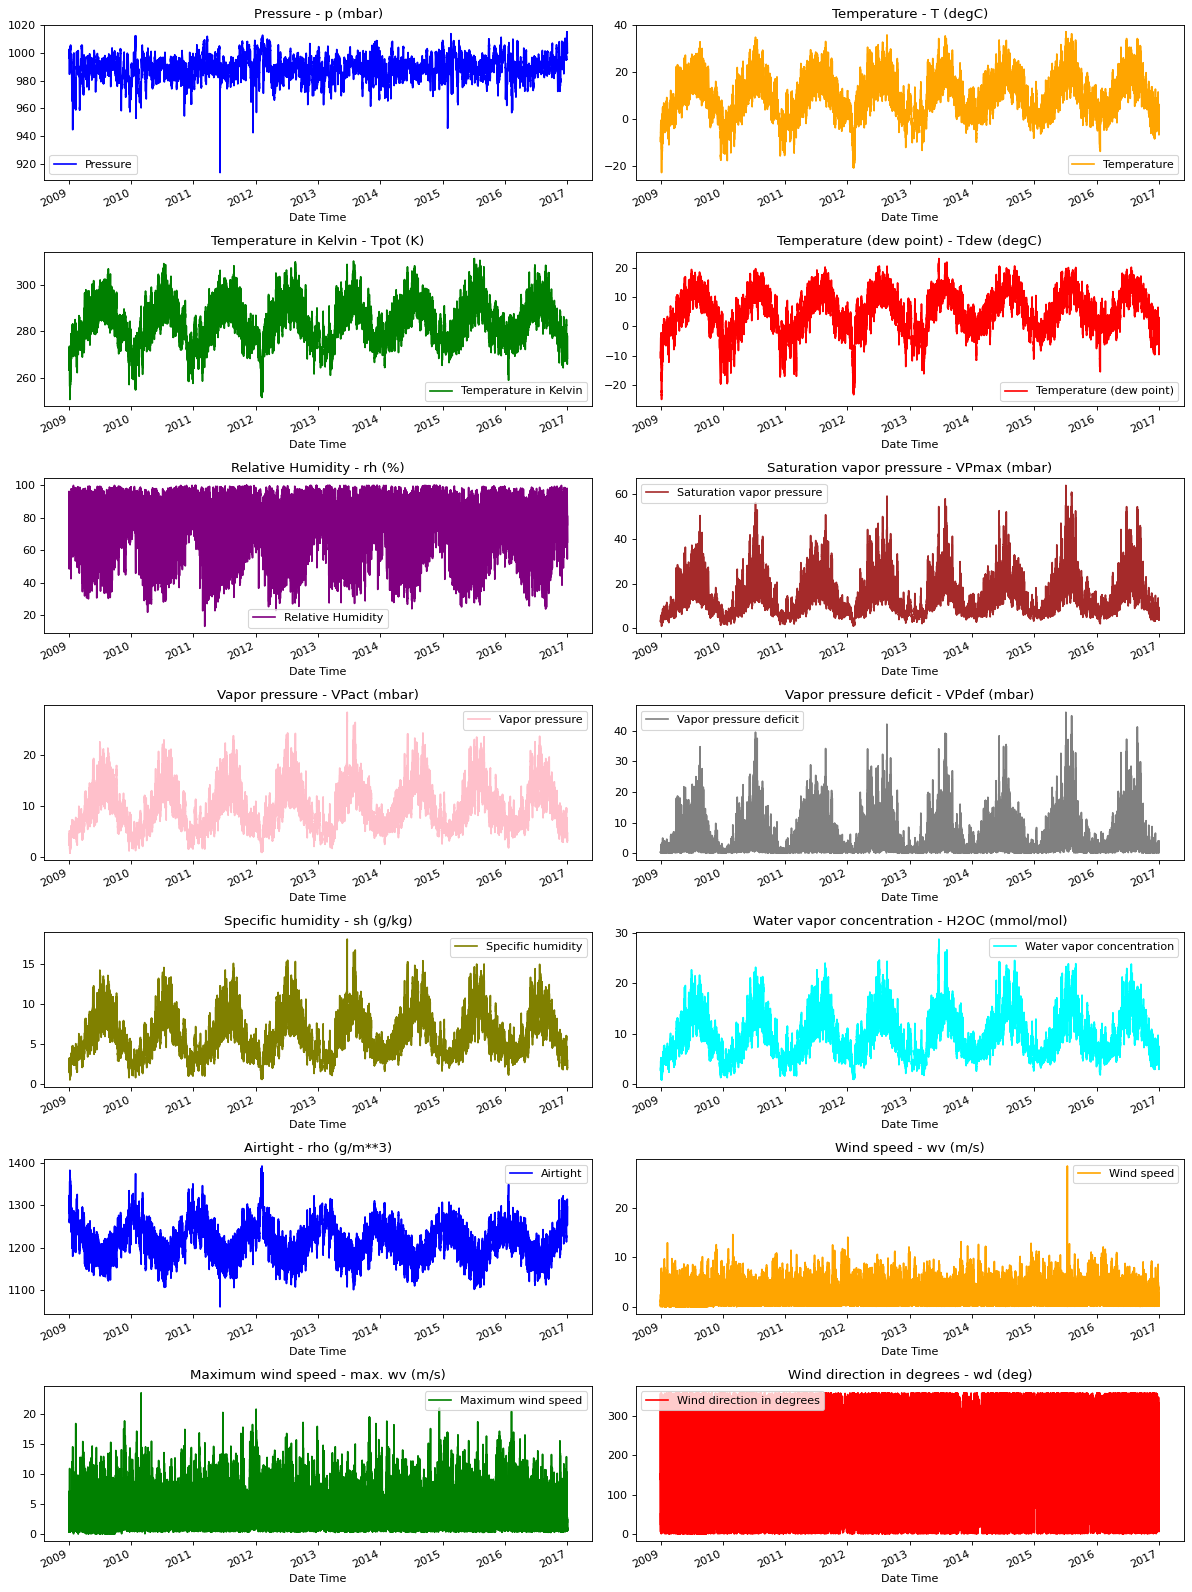

In [85]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

In [86]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
print(train_split)

300693


In [87]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [88]:
print(
    "The selected parameters are:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)

selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
print(features.head().to_markdown(numalign="left", stralign="left"))

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
print(features.head().to_markdown(numalign="left", stralign="left"))


start = past + future # this means start of y label
end = start + train_split # this means end of y label

# train_data = features.loc[0 : train_split - 1]
x_train = features.iloc[0 : train_split][[i for i in range(7)]].values # the number of rows of train_data is train_split <- features.loc[0 : train_split - 1]
y_train = features.iloc[start:end][[1]]


val_data = features.loc[train_split:]
x_end = len(val_data) - past - future
label_start = train_split + past + future

x_val = features.iloc[train_split:(features.shape[0]-past-future)][[i for i in range(7)]].values
y_val = features.iloc[(train_split+past+future):][[1]]

The selected parameters are: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed
| Date Time           | p (mbar)   | T (degC)   | VPmax (mbar)   | VPdef (mbar)   | sh (g/kg)   | rho (g/m**3)   | wv (m/s)   |
|:--------------------|:-----------|:-----------|:---------------|:---------------|:------------|:---------------|:-----------|
| 2009-01-01 00:10:00 | 996.52     | -8.02      | 3.33           | 0.22           | 1.94        | 1307.75        | 1.03       |
| 2009-01-01 00:20:00 | 996.57     | -8.41      | 3.23           | 0.21           | 1.89        | 1309.8         | 0.72       |
| 2009-01-01 00:30:00 | 996.53     | -8.51      | 3.21           | 0.2            | 1.88        | 1310.24        | 0.19       |
| 2009-01-01 00:40:00 | 996.51     | -8.31      | 3.26           | 0.19           | 1.92        | 1309.19        | 0.34       |
| 2009-01-01 00:50:00 | 996.51     | -8.27      | 3.27           | 0.19           | 1.92 

In [89]:
x_train.shape

(300693, 7)

In [76]:
# Flatten the 3D array into 2D (as XGBoost expects a 2D input)
x_train = x_train.reshape(x_train.shape[0], -1)
x_val = x_val.reshape(x_val.shape[0], -1)

In [45]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((300693, 7), (300693, 1), (119066, 7), (119066, 1))

In [63]:
# Define the XGBoost regressor
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, random_state=42, eval_metric='rmse', early_stopping_rounds=20)

# Train the model
xgb_model.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=False)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [60]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Get the predictions on the validation set
y_pred_val = xgb_model.predict(x_val)

# Calculate RMSE
mse_val = (mean_squared_error(y_val, y_pred_val))

print(f"Manually Calculated MSE: {mse_val}")

Manually Calculated MSE: 0.46970242481379487


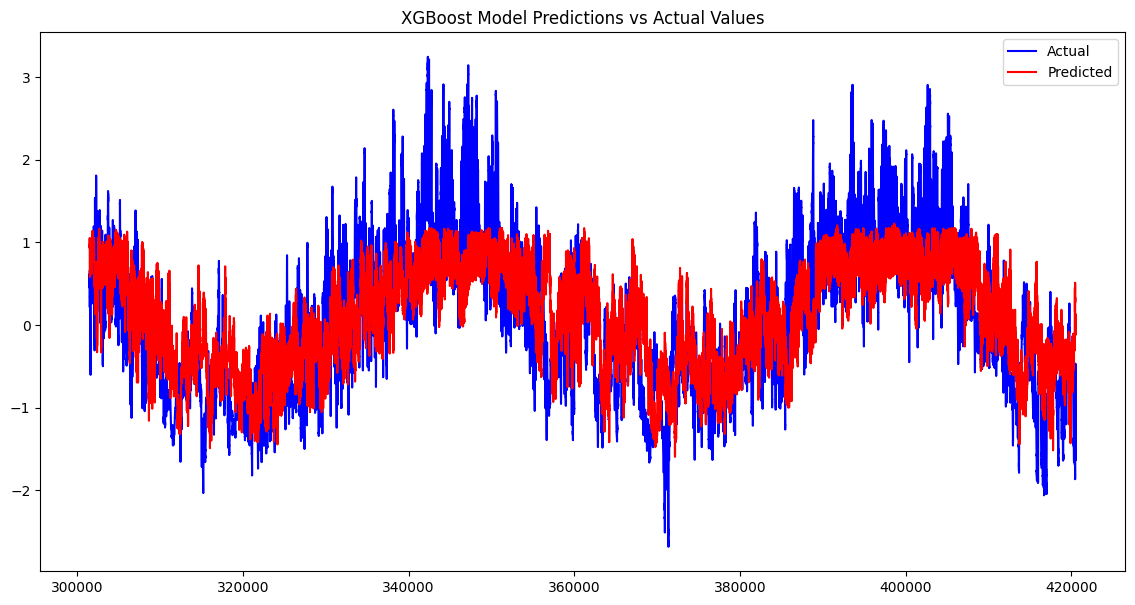

In [62]:
# create the time series graph with the predicted values and the actual values
# firstly set the index of the y_val to the index of the val_data
y_val.index = val_data.index[past+future:]
# create the time series graph with the predicted values and the actual values
plt.figure(figsize=(14, 7))
plt.plot(y_val, label='Actual', color='blue')
plt.plot(y_val.index, y_pred_val, label='Predicted', color='red')
plt.title('XGBoost Model Predictions vs Actual Values')
plt.legend()